In [1]:
pip install mat4py

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 258.0/258.0 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/79/3d/02d5d3ed359498fec3abdf65407d3c07e3b8765af17464969055aaec5171/scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ----------- ---------------------------- 3.1/10.6 MB 64.7 MB/s eta 0:00:01
   ------------------------------- -------- 8.3/10.6 MB 106.9 MB/s eta 0:00:01
   ---------------------------------------  10.6/10.6 MB 108.8 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import pandas as pd
from mat4py import loadmat
import sklearn
import imblearn
from scipy.signal import find_peaks, savgol_filter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE

In [33]:
#Loading and processing the data
class EmoPainData:
    def __init__(self, control_dir, pain_dir):
        self.control_dir = control_dir
        self.pain_dir = pain_dir
        self.all_features = pd.DataFrame()

        self.process_directory(self.control_dir, 'Control')
        self.process_directory(self.pain_dir, 'Pain')
        print("Processing complete, features added.")

    def process_directory(self, directory, group):
        for file in os.listdir(directory):
            if file.endswith('.mat'):
                pid, ed = self.parse_filename(file)
                data = self.load_data(os.path.join(directory, file))
                if data is not None and data.shape[1] > 160:
                    feature_extractor = EmoPainFeatureExtractor(data)
                    features = feature_extractor.extract_features()
                    features['pid'] = pid
                    features['ED'] = ed
                    features['Group'] = group
                    self.all_features = pd.concat([self.all_features, features], ignore_index=True)
                print(f"Features processed for PID: {pid}{ed}")

    def parse_filename(self, filename):
        parts = filename.split('_')
        return parts[0], parts[1].replace('.mat', '')

    def load_data(self, filepath):
        data = loadmat(filepath)
        if 'data_extended' in data:
            return np.array(data['data_extended'])
        elif 'motionfeature' in data:
            return np.array(data['motionfeature'])
        else:
            return None

In [34]:
#Feature extraction
class EmoPainFeatureExtractor:
    def __init__(self, data_matrix):
        self.data_matrix = data_matrix

    def extract_features(self):
        features = {
            'Range_Neck_Bending': [self.calculate_range_neck_bending()],
            'Flexion_Angles': [self.calculate_flexion_angles()],
            'Left_Arm_Peak_Features': [self.calculate_left_arm_peak_features()],
            'EMG_Change_Point_Features': [self.calculate_emg_change_point_features()]
        }
        return pd.DataFrame(features)

    def calculate_range_neck_bending(self):
        return np.max(self.data_matrix[:, 24]) - np.min(self.data_matrix[:, 12])

    def calculate_flexion_angles(self):
        max_flexion = np.max(self.data_matrix[:, 138])
        min_flexion = np.min(self.data_matrix[:, 137])
        return max_flexion - min_flexion

    def calculate_left_arm_peak_features(self):
        inclination = self.data_matrix[:, 15] - self.data_matrix[:, 16]
        filtered_inclination = savgol_filter(inclination, window_length=5, polyorder=2)
        peaks, properties = find_peaks(filtered_inclination, height=True)
        return np.mean(properties['peak_heights']) if peaks.size > 0 else 0

    def calculate_emg_change_point_features(self):
        emg_columns = [79, 80, 81, 82]
        change_point_differences = np.max(self.data_matrix[:, emg_columns], axis=0) - np.min(self.data_matrix[:, emg_columns], axis=0)
        return np.mean(change_point_differences)

Features processed for PID: C31D
Features processed for PID: C31N
Features processed for PID: C32D
Features processed for PID: C34D
Features processed for PID: C34N
Features processed for PID: C35D
Features processed for PID: C36D
Features processed for PID: C42D
Features processed for PID: C42N
Features processed for PID: C43D
Features processed for PID: C43N
Features processed for PID: C47D
Features processed for PID: C47N
Features processed for PID: C50D
Features processed for PID: C55D
Features processed for PID: C60D
Features processed for PID: C60N
Features processed for PID: C63D
Features processed for PID: C65N
Features processed for PID: C66D
Features processed for PID: C66N
Features processed for PID: C68D
Features processed for PID: C68N
Features processed for PID: C75N
Features processed for PID: C78D
Features processed for PID: C78N
Features processed for PID: C80D
Features processed for PID: C80N
Features processed for PID: C82D
Features processed for PID: C82N
Features p

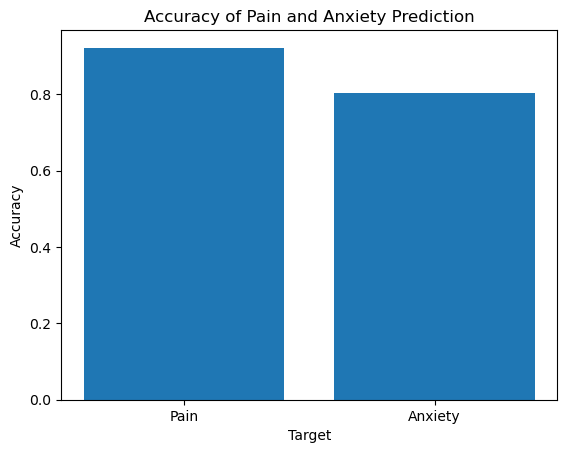

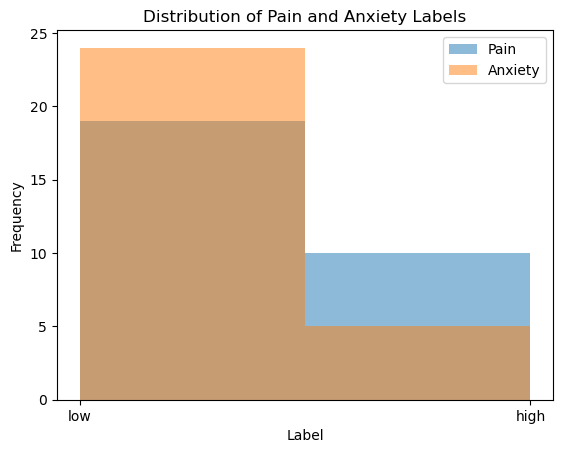

In [35]:
def main():
    control_directory = 'randomised_C'
    pain_directory = 'randomised_P'
    emo_pain_data = EmoPainData(control_directory, pain_directory)

    self_report_df = pd.read_csv('randomised_Self_Report_P.csv')
    combined_data = pd.merge(emo_pain_data.all_features, self_report_df, left_on='pid', right_on='patient no', how='inner')
    combined_data.fillna(combined_data.mean(numeric_only=True), inplace=True)

    pain_columns = [col for col in combined_data.columns if 'pn' in col and not col.endswith('arrive')]
    anxiety_columns = [col for col in combined_data.columns if 'anx' in col and not col.endswith('arrive')]
    relevant_columns = pain_columns + anxiety_columns + ['pn arrive', 'anx arrive']
    combined_data = combined_data[relevant_columns]
    combined_data = combined_data.select_dtypes(include=[np.number])
    combined_data.fillna(combined_data.mean(), inplace=True)

    combined_data['pain_label'] = np.where(combined_data['pn arrive'] < 5, 'low', 'high')
    combined_data['anxiety_label'] = np.where(combined_data['anx arrive'] < 5, 'low', 'high')

    X = combined_data.drop(['pn arrive', 'anx arrive', 'pain_label', 'anxiety_label'], axis=1)
    y_pain = combined_data['pain_label']
    y_anxiety = combined_data['anxiety_label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    # Determine the minimum number of neighbors to use for SMOTE
    min_neighbors_pain = max(min(y_pain.value_counts()) - 1, 1)  # at least 1 neighbor
    min_neighbors_anxiety = max(min(y_anxiety.value_counts()) - 1, 1)

    smote_pain = SMOTE(k_neighbors=min_neighbors_pain)
    borderline_smote_anxiety = BorderlineSMOTE(k_neighbors=min(len(y_anxiety[y_anxiety == label]) - 1 for label in np.unique(y_anxiety)) or 1, kind='borderline-1')


    #applying SMOTE to pain
    X_pain_resampled, y_pain_resampled = smote_pain.fit_resample(X_scaled, y_pain)
    # Applying Borderline SMOTE to the anxiety data
    X_anxiety_resampled, y_anxiety_resampled = borderline_smote_anxiety.fit_resample(X_scaled, y_anxiety)


    # Separate cross-validation for pain and anxiety
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model_pain = SVC(kernel='linear', class_weight='balanced', C=0.1)
    model_anxiety = SVC(kernel='rbf', class_weight='balanced', C=0.05)

    # Cross-validation for Pain
    scores_pain = cross_validate(model_pain, X_pain_resampled, y_pain_resampled, cv=skf, return_indices=True,
                                 scoring={'accuracy': 'accuracy', 'f1': 'f1_macro', 'recall': 'recall_macro'}, return_estimator=True)
    pain_accuracy = np.mean(scores_pain['test_accuracy'])
    pain_f1 = np.mean(scores_pain['test_f1'])
    pain_recall = np.mean(scores_pain['test_recall'])
    
    pain_confusion_matrix = np.zeros([2, 2])
    for train_index, test_index in skf.split(X_pain_resampled, y_pain_resampled):
        model = model_pain.fit(X_pain_resampled[train_index], y_pain_resampled[train_index])
        test_predictions = model.predict(X_pain_resampled[test_index])
        pain_confusion_matrix += confusion_matrix(y_pain_resampled[test_index], test_predictions, labels=np.unique(y_pain_resampled))

    print("Average Accuracy for Pain Prediction:", pain_accuracy)
    print("F1-Score for Pain Prediction:", pain_f1)
    print("Recall for Pain Prediction:", pain_recall)
    print("Confusion Matrix for Pain Prediction:\n", pain_confusion_matrix)

    #Cross-validation for anxiety
    scores_anxiety = cross_validate(model_anxiety, X_anxiety_resampled, y_anxiety_resampled, cv=skf, return_indices=True,
                                scoring={'accuracy': 'accuracy', 'f1': 'f1_macro', 'recall': 'recall_macro'}, return_estimator=True)
    anxiety_accuracy = np.mean(scores_anxiety['test_accuracy'])
    anxiety_f1 = np.mean(scores_anxiety['test_f1'])
    anxiety_recall = np.mean(scores_anxiety['test_recall'])
    
    anxiety_confusion_matrix = np.zeros([2, 2])
    for train_index, test_index in skf.split(X_anxiety_resampled, y_anxiety_resampled):
        model = model_pain.fit(X_anxiety_resampled[train_index], y_anxiety_resampled[train_index])
        test_predictions = model.predict(X_anxiety_resampled[test_index])
        anxiety_confusion_matrix += confusion_matrix(y_anxiety_resampled[test_index], test_predictions, labels=np.unique(y_anxiety_resampled))

    print("Average Accuracy for Anxiety Prediction:", anxiety_accuracy)
    print("F1-Score for Anxiety Prediction:", anxiety_f1)
    print("Recall for Anxiety Prediction:", anxiety_recall)
    print("Confusion Matrix for Anxiety Prediction:\n", anxiety_confusion_matrix)

      

    # Visualization of accuracy
    plt.bar(['Pain', 'Anxiety'], [pain_accuracy, anxiety_accuracy])
    plt.xlabel('Target')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Pain and Anxiety Prediction')
    plt.show()
    
    # Distribution of pain and anxiety labels
    plt.hist(y_pain, bins=2, alpha=0.5, label='Pain')
    plt.hist(y_anxiety, bins=2, alpha=0.5, label='Anxiety')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pain and Anxiety Labels')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
